In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from glob import glob
from collections import defaultdict

import matplotlib.pyplot as plt

import re

from collections import Counter
import statsmodels.api as sm

import seaborn as sns
from urlparse import urlsplit, parse_qs

from sklearn.feature_extraction import DictVectorizer

from IPython.display import display

/home/entity/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:279: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
sns.set_context("poster")
sns.set_style("ticks")

In [3]:
TOPIC_MAPPING={
    "GunControl": "Gun Control",
    "Privacy": "Privacy",
    "Vaccine": "Vaccine",
    "ChildEducation": "Child Education",
    "SkinDamage": "Skin Damage",
    "SeatBelt": "Seat Belt"
}
topic_order=["Gun Control", "Privacy", "Vaccine",
             "Child Education", "Skin Damage", "Seat Belt"]
df = pd.read_hdf("FINAL_ANALYSIS_DATA.h5", "final_data").rename(columns={
        #u'is_controvertial': u'is_controversial'
    }).assign(
    topic_name=lambda x: x.topic_name.apply(lambda k: TOPIC_MAPPING[k.split('/')[0]]),
)
df.shape

(246869, 54)

In [4]:
print ("Total instances in data is %s,\n"
       " with URLs is %s (%.2f%%),\n"
       " with user locations is %s (%.2f%%),\n"
       " and with gender is %s (%.2f%%)") % (
    df.shape[0],
    df[df.t_n_urls > 0].shape[0], df[df.t_n_urls > 0].shape[0]*100./ df.shape[0],
    df[~df.u_state.isnull()].shape[0], df[~df.u_state.isnull()].shape[0]*100./ df.shape[0],
    df[~df.Gender.isnull()].shape[0], df[~df.Gender.isnull()].shape[0]*100./ df.shape[0],
)


pd.DataFrame({
        "Overall": df.topic_name.value_counts(), 
        "With URLs": df[df.t_n_urls > 0].topic_name.value_counts(), 
        "With user locations": df[~df.u_state.isnull()].topic_name.value_counts(), 
        "With user gender": df[~df.Gender.isnull()].topic_name.value_counts(), 
    })#.sort_values("Overall")

Total instances in data is 246869,
 with URLs is 101640 (41.17%),
 with user locations is 169038 (68.47%),
 and with gender is 132125 (53.52%)


,Overall,With URLs,With user gender,With user locations
Child Education,10808,5601,5054,8142
Gun Control,34357,17139,18598,24009
Privacy,73593,33006,40583,53368
Seat Belt,73270,14842,38653,43219
Skin Damage,14128,7777,6915,11162
Vaccine,40713,23275,22322,29138


In [5]:
df[~df.Gender.isnull()].Gender.value_counts()

M    76665
F    55460
Name: Gender, dtype: int64

In [6]:
df.u_location.value_counts().head()

United States      6906
USA                5284
Washington, DC     3431
New York, NY       2225
Los Angeles, CA    1979
Name: u_location, dtype: int64

In [7]:
df.u_location.value_counts().shape

(45905,)

In [8]:
df.columns

Index([          u'Author',       u'City/Urban',  u'City/Urban Area',
               u'Contents',             u'Date',        u'Followers',
              u'Following',             u'GUID',           u'Gender',
                   u'Name',            u'Posts',              u'RT?',
           u'State/Region',              u'URL',             u'URL?',
              u'adjective',           u'adverb',      u'count_tweet',
               u'hashtag?',         u'mention?',         u'negation',
                   u'noun',      u'preposition',    u'processedPost',
              u'sentiment',   u'sentiment_subj', u'subjectvity_type',
                   u't_id',       u'topic_name',             u'verb',
              u't_created',       u't_retweets',      u't_favorites',
             u't_is_reply',       u't_is_quote',     u't_n_hashtags',
               u't_n_urls',     u't_n_mentions',        u't_n_media',
                   u'u_id',        u'u_created',       u'u_n_listed',
          u'u_n_favo

In [9]:
df[~df.CATS.isnull()].CATS.head()

13      [news]
14      [news]
15       [UNK]
16    [videos]
19      [blog]
Name: CATS, dtype: object

In [10]:
CAT_MAPPINGS={
    "satire": "fakenews",
    "clickbait": "fakenews",
    "usgov": "news"
}
def get_category_counts(x):
    if x == 0:
        return Counter(["NONE"])
    c = Counter([CAT_MAPPINGS.get(k,k) for k in x])
    if "twitter" in c:
        c = Counter({"twitter": c["twitter"]})
    return c

In [11]:
df.CATS.fillna(0).apply(get_category_counts).head()

0    {u'NONE': 1}
1    {u'NONE': 1}
2    {u'NONE': 1}
3    {u'NONE': 1}
4    {u'NONE': 1}
Name: CATS, dtype: object

In [12]:
df.CATS.fillna(0).apply(get_category_counts).apply(lambda x: len(x)).describe()

count    246869.000000
mean          1.037931
std           0.196466
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           4.000000
Name: CATS, dtype: float64

In [13]:
df[~df.CATS.isnull()].CATS.head()

13      [news]
14      [news]
15       [UNK]
16    [videos]
19      [blog]
Name: CATS, dtype: object

In [14]:
df["CATS_Counter"] = df.CATS.fillna(0).apply(get_category_counts)
df.ix[df.CATS_Counter.apply(lambda x: len(x)) == 2, "CATS_Counter"].head()

23     {u'socialmedia': 1, u'videos': 1}
38     {u'socialmedia': 1, u'videos': 1}
53     {u'socialmedia': 1, u'videos': 1}
87        {u'news': 1, u'scientific': 1}
138    {u'socialmedia': 1, u'videos': 1}
Name: CATS_Counter, dtype: object

In [15]:
df.ix[df.CATS_Counter.apply(lambda x: len(x)) == 2, "CATS_Counter"].shape

(8862,)

In [16]:
pd.Series(sum(df.CATS_Counter.values[1:], df.CATS_Counter.values[0])).to_frame().reset_index()

,index,0
0,NONE,145229
1,UNK,30663
2,blog,6349
3,commercial,3654
4,fakenews,8375
5,news,19491
6,scientific,674
7,socialmedia,13745
8,twitter,23118
9,videos,7230


In [17]:
%%time
df_X = df.CATS_Counter.apply(lambda x: pd.Series(x)).fillna(0.)
df_y = df.is_controversial * 1.

CPU times: user 1min 36s, sys: 2.67 s, total: 1min 39s
Wall time: 1min 38s


In [18]:
df_X.head()

,NONE,UNK,blog,commercial,fakenews,news,scientific,socialmedia,twitter,videos
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
model = sm.Logit(df_y, df_X)
res = model.fit()
res.summary2()

Optimization terminated successfully.
         Current function value: 0.628661
         Iterations 8


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.065      
Dependent Variable: is_controversial AIC:              310413.9147
Date:               2017-03-12 20:02 BIC:              310518.0809
No. Observations:   246869           Log-Likelihood:   -1.5520e+05
Df Model:           9                LL-Null:          -1.6592e+05
Df Residuals:       246859           LLR p-value:      0.0000     
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     8.0000                                        
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
NONE           0.0724    0.0053   13.7917  0.0000   0.0621   0.0827
UNK            0.7346    0.0122   60.2838  0.0000   0.7108   0.7585
blog           2.0246    0.0392   51.5891  0.0000   1.9476   2.1015
commercial     0.3305    0.0339    9.7370  0.0000   0.2640   0.3970
fakenews       3.0580    0.0660   46.2990  0.0000   2.9286   3.1875
news           2.0590    0.0233   88.4545  0.0000   2.0134   2.1046
scientific     1.0698    0.1041   10.2784  0.0000   0.8658   1.2738
socialmedia   -0.2513    0.0249  -10.1077  0.0000  -0.3000  -0.2026
twitter        0.6729    0.0139   48.3966  0.0000   0.6457   0.7002
videos         0.3852    0.0340   11.3459  0.0000   0.3187   0.4518
==================================================================

"""

In [20]:
res.get_margeff(at="zero").summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
        Logit Marginal Effects       
=====================================
Dep. Variable:       is_controversial
Method:                          dydx
At:                              zero
===============================================================================
                 dy/dx    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
NONE            0.0181      0.001     13.792      0.000         0.016     0.021
UNK             0.1837      0.003     60.284      0.000         0.178     0.190
blog            0.5061      0.010     51.589      0.000         0.487     0.525
commercial      0.0826      0.008      9.737      0.000         0.066     0.099
fakenews        0.7645      0.017     46.299      0.000         0.732     0.797
news            0.5148      0.006     88.454      0.000         0.503     0.526
scientific      0.2675      0.026     10.278      0.000         0.216     0.318
socialmedia    -0.0628      0.006    -10.108      0.000        -0.075    -0.051
twitter         0.1682      0.003     48.397      0.000         0.161     0.175
videos          0.0963      0.008     11.346      0.000         0.080     0.113
===============================================================================
"""

In [21]:
model = sm.Logit(df_y[(df.t_n_urls > 0)], df_X[(df.t_n_urls > 0)].drop("NONE", axis=1))
res = model.fit()
res.summary2()

Optimization terminated successfully.
         Current function value: 0.537456
         Iterations 8


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.090      
Dependent Variable: is_controversial AIC:              109272.1055
Date:               2017-03-12 20:02 BIC:              109357.8682
No. Observations:   101640           Log-Likelihood:   -54627.    
Df Model:           8                LL-Null:          -60040.    
Df Residuals:       101631           LLR p-value:      0.0000     
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     8.0000                                        
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
UNK            0.7346    0.0122   60.2838  0.0000   0.7108   0.7585
blog           2.0246    0.0392   51.5891  0.0000   1.9476   2.1015
commercial     0.3305    0.0339    9.7370  0.0000   0.2640   0.3970
fakenews       3.0580    0.0660   46.2990  0.0000   2.9286   3.1875
news           2.0590    0.0233   88.4545  0.0000   2.0134   2.1046
scientific     1.0698    0.1041   10.2784  0.0000   0.8658   1.2738
socialmedia   -0.2513    0.0249  -10.1077  0.0000  -0.3000  -0.2026
twitter        0.6729    0.0139   48.3966  0.0000   0.6457   0.7002
videos         0.3852    0.0340   11.3459  0.0000   0.3187   0.4518
==================================================================

"""

In [22]:
df.topic_name.value_counts()

Privacy            73593
Seat Belt          73270
Vaccine            40713
Gun Control        34357
Skin Damage        14128
Child Education    10808
Name: topic_name, dtype: int64

CPU times: user 55.5 s, sys: 5.04 s, total: 1min
Wall time: 59 s


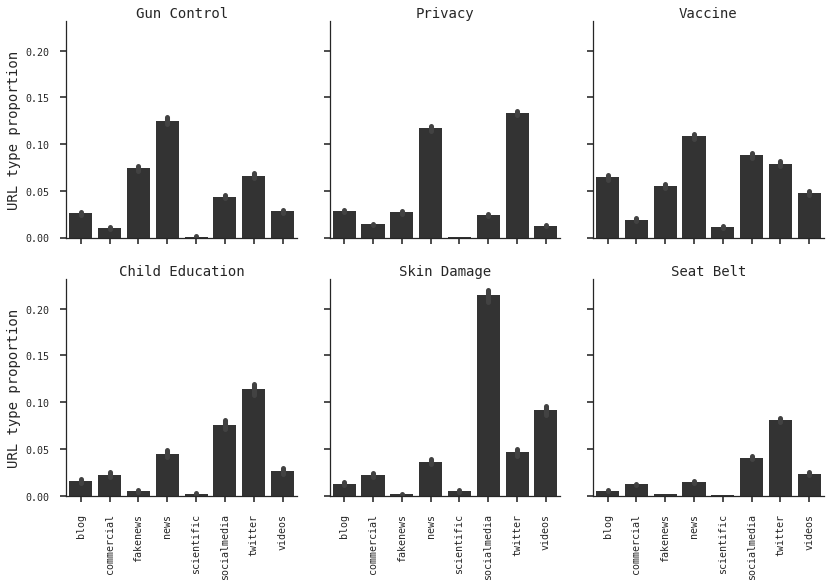

In [23]:
%%time
with sns.plotting_context(
    rc={"axes.titlesize": 14,
        "axes.labelsize": 14,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
       }), sns.axes_style(
    rc={"font.family": "monospace"}):
    g = sns.factorplot(x="URL_type", y="URL_counts", #hue="is_controversial",
                   col="topic_name", col_wrap=3, 
                       col_order=topic_order,
                       kind="bar",
                       color="0.2",
                  data=pd.melt(pd.concat([df_X > 0,
                                          df[["topic_name"]],
                                          (df_y == 1).to_frame()],
                      axis=1).drop(["NONE", "UNK"], axis=1),
                               id_vars=["is_controversial", "topic_name"],
            var_name="URL_type", value_name="URL_counts"
           ))
    g.set_xticklabels(rotation=90).set_titles("{col_name}").set_axis_labels("", "URL type proportion")
    #sns.despine(offset=10)

CPU times: user 21.5 s, sys: 668 ms, total: 22.2 s
Wall time: 22.2 s


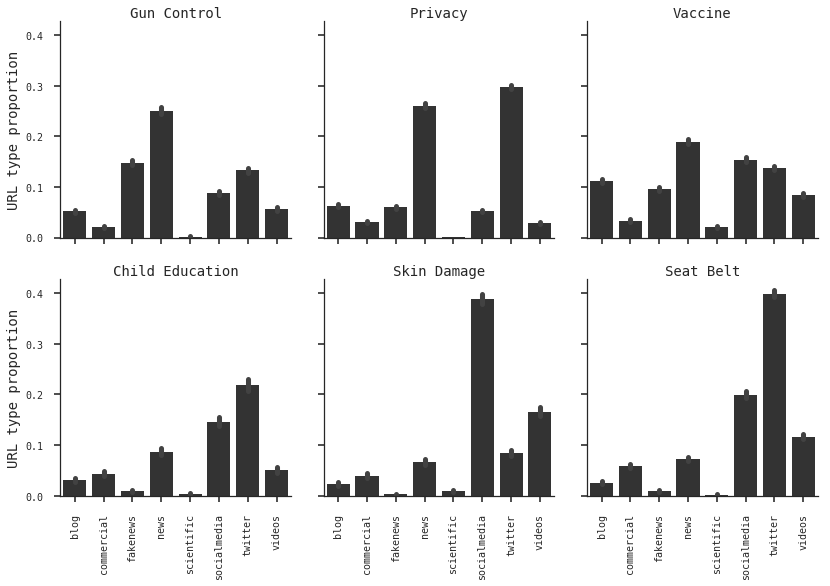

In [24]:
%%time
with sns.plotting_context(
    rc={"axes.titlesize": 14,
        "axes.labelsize": 14,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
       }), sns.axes_style(
    rc={"font.family": "monospace"}):
    g = sns.factorplot(x="URL_type", y="URL_counts", #hue="is_controversial",
                   col="topic_name", col_wrap=3, 
                       col_order=topic_order,
                       kind="bar",
                       color="0.2",
                  data=pd.melt(pd.concat([df_X[df.t_n_urls > 0] > 0,
                                          df[df.t_n_urls > 0][["topic_name"]],
                                          (df_y[df.t_n_urls > 0] == 1).to_frame()],
                      axis=1).drop(["NONE", "UNK"], axis=1),
                               id_vars=["is_controversial", "topic_name"],
            var_name="URL_type", value_name="URL_counts"
           ))
    g.set_xticklabels(rotation=90).set_titles("{col_name}").set_axis_labels("", "URL type proportion")
    #sns.despine(offset=10)

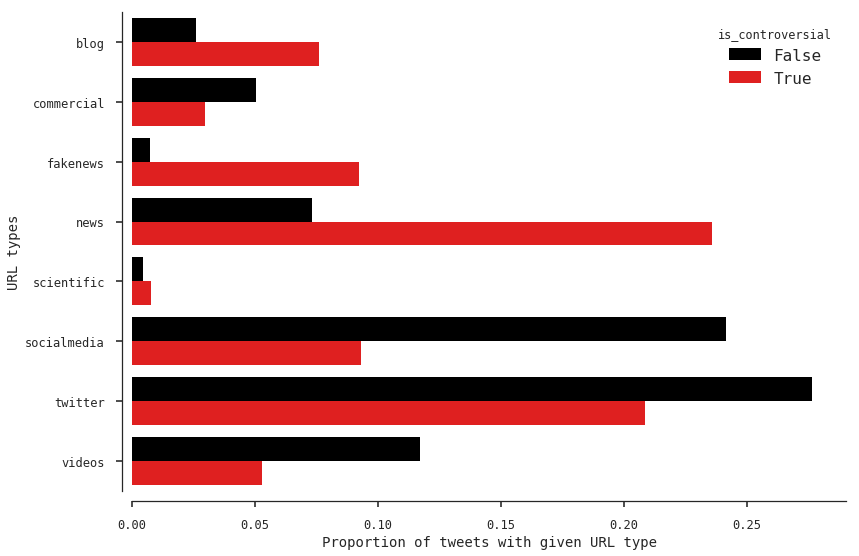

In [25]:
with sns.plotting_context(
    rc={"axes.titlesize": 14,
        "axes.labelsize": 14,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
       }), sns.axes_style(
    rc={"font.family": "monospace"}):
    ax = sns.barplot(x="mean", y="index", hue="is_controversial",
                data=pd.concat([
            ((df_X[(df_y == 0) & (df.t_n_urls > 0)].drop(["NONE", "UNK",], axis=1) > 0)* 1.).describe().T.reset_index().assign(is_controversial=False),
            ((df_X[(df_y == 1) & (df.t_n_urls > 0)].drop(["NONE", "UNK",], axis=1) > 0)* 1.).describe().T.reset_index().assign(is_controversial=True),
              ], axis=0),
                     palette=["k", "r"]
                    )
    ax.set_xlabel("Proportion of tweets with given URL type")
    ax.set_ylabel("URL types")
    sns.despine(offset=10)

In [26]:
(
    ((df_X[(df_y == 1) & (df.t_n_urls > 0)].drop(["NONE"], axis=1) > 0)* 1.).describe().T["mean"]/
    ((df_X[(df_y == 0) & (df.t_n_urls > 0)].drop(["NONE"], axis=1) > 0)* 1.).describe().T["mean"]
).to_frame().reset_index().rename(columns={"index": "URL type", "mean": "Odds in controversial topic"})

,URL type,Odds in controversial topic
0,UNK,0.833711
1,blog,2.935238
2,commercial,0.588296
3,fakenews,12.942165
4,news,3.226718
5,scientific,1.755262
6,socialmedia,0.386396
7,twitter,0.753418
8,videos,0.449879


## Aggregate counts

In [27]:
df.shape

(246869, 55)

In [28]:
df[df.t_n_urls > 0].shape

(101640, 55)

In [29]:
df.t_n_urls.sum()

104279.0

In [30]:
df.topic_name.value_counts().to_frame()

,topic_name
Privacy,73593
Seat Belt,73270
Vaccine,40713
Gun Control,34357
Skin Damage,14128
Child Education,10808


## URL Analysis

In [31]:
def sum_url_present(x):
    return (x>0).sum()
def mean_url_present(x):
    return (x>0).mean()


def get_url_domain(x):
    x = urlsplit(x.lower())
    if x.netloc in {"linkis.com", "www.linkis.com"}:
        if x.path[1:] != "":
            x = urlsplit("http:/%s" % x.path).netloc
        else:
            x = x.netloc
    elif x.netloc in {"google.com", "www.google.com"}:
        query = parse_qs(x.query)
        if "url" in query:
            return get_url_domain(query["url"][0])
        x = x.netloc
    else:
        x = x.netloc
    if x.startswith("www."):
        x = x[4:]
    if x.endswith(".wordpress.com") or x.endswith(".tumblr.com") or x.endswith(".blogspot.com"):
        x = x.split(".", 1)[-1]
    return x

print get_url_domain("https://www.google.com/url?rct=j&sa=t&url=http://www.perthnow.com.au/news/western-australia/social-services-minister-christian-porter-slaps-down-antivaccination-campaigners/news-story/0aa49052ec0598704b05333075581296&ct=ga&cd=CAIyGjE2ZDBhYmZjOTAzMjkyMTk6Y29tOmVuOlVT&usg=AFQjCNFAB3aZtdfdVpXOHWzyfqsu0ZSFAg")

perthnow.com.au


In [32]:
df.groupby("topic_name")["t_n_urls"].agg([len, np.sum, np.mean,
                                          sum_url_present, mean_url_present]).sort_values("mean", ascending=False)

,len,sum,mean,sum_url_present,mean_url_present
topic_name,,,,,
Vaccine,40713.0,24143.0,0.621377,23275.0,0.571685
Skin Damage,14128.0,7934.0,0.586748,7777.0,0.550467
Child Education,10808.0,5718.0,0.553426,5601.0,0.518227
Gun Control,34357.0,17616.0,0.551172,17139.0,0.498850
Privacy,73593.0,33693.0,0.483338,33006.0,0.448494
Seat Belt,73270.0,15175.0,0.225714,14842.0,0.202566


In [33]:
df_urls = pd.read_csv("TID_URL_CATS.txt", sep="\t")
df_urls["ORIG_DOMAIN"] = df_urls.URL.apply(get_url_domain)
df_urls.head()

,TID,URL,CATS,ORIG_DOMAIN
0,682904901916225536,https://twitter.com/photogchad_WTSP/status/682...,socialmedia|twitter,twitter.com
1,682915876316692480,http://www.investirdanslenfance.ca/,UNK,investirdanslenfance.ca
2,682985833821941760,http://TinyURL.com/NewYearCure,commercial,tinyurl.com
3,682952771746664448,http://TinyURL.com/NewYearCure,commercial,tinyurl.com
4,682830450969059328,http://yournewswire.com/donald-trump-vaccines-...,fakenews,yournewswire.com


In [34]:
df_url_exp = pd.read_csv("URL_CAT_MAPPINGS.txt", sep="\t")
df_url_exp.head()

,URL,EXPANDED,EXPANDED_STATUS,URL_DOMAIN,URL_CATS
0,http://www.investmentnews.com/article/20160801...,http://www.investmentnews.com/article/20160801...,0,investmentnews.com,UNK
1,http://ow.ly/3avNPe,https://www.reddit.com/r/cahideas/comments/42i...,0,reddit.com,socialmedia
2,http://stratcom.kma-assc.com/uncategorized/pre...,http://stratcom.kma-assc.com/uncategorized/pre...,3,stratcom.kma-assc.com,UNK
3,http://ln.is/mabelsaveforschool.com/gbEtv,http://linkis.com/mabelsaveforschool.com/gbEtv,0,mabelsaveforschool.com,commercial
4,http://kiw.im/16LfJirkfzE,https://kiwi.qa/LFHKX8RLIFI7O8/39656070290663927,0,kiwi.qa,UNK


In [35]:
df_urls.shape, df_url_exp.shape

((166670, 4), (97512, 5))

In [36]:
df_urls = df_urls.merge(df_url_exp, how="left", on="URL")
df_urls.head()

,TID,URL,CATS,ORIG_DOMAIN,EXPANDED,EXPANDED_STATUS,URL_DOMAIN,URL_CATS
0,682904901916225536,https://twitter.com/photogchad_WTSP/status/682...,socialmedia|twitter,twitter.com,NaN,NaN,NaN,NaN
1,682915876316692480,http://www.investirdanslenfance.ca/,UNK,investirdanslenfance.ca,http://www.investirdanslenfance.ca/,0.0,investirdanslenfance.ca,UNK
2,682985833821941760,http://TinyURL.com/NewYearCure,commercial,tinyurl.com,https://video214.com/play/8oLgDB1QXRWpXPysTSg1...,0.0,video214.com,commercial
3,682952771746664448,http://TinyURL.com/NewYearCure,commercial,tinyurl.com,https://video214.com/play/8oLgDB1QXRWpXPysTSg1...,0.0,video214.com,commercial
4,682830450969059328,http://yournewswire.com/donald-trump-vaccines-...,fakenews,yournewswire.com,http://yournewswire.com/donald-trump-vaccines-...,0.0,yournewswire.com,fakenews


In [37]:
## Update data for twitter urls
df_urls.ix[df_urls.EXPANDED.isnull(), "EXPANDED_STATUS"] = 0
df_urls.ix[df_urls.EXPANDED.isnull(), "URL_DOMAIN"] = df_urls.ix[df_urls.EXPANDED.isnull(), "ORIG_DOMAIN"]
df_urls.ix[df_urls.EXPANDED.isnull(), "URL_CATS"] = df_urls.ix[df_urls.EXPANDED.isnull(), "CATS"]
df_urls.ix[df_urls.EXPANDED.isnull(), "EXPANDED"] = df_urls.ix[df_urls.EXPANDED.isnull(), "URL"]
df_urls.head()

,TID,URL,CATS,ORIG_DOMAIN,EXPANDED,EXPANDED_STATUS,URL_DOMAIN,URL_CATS
0,682904901916225536,https://twitter.com/photogchad_WTSP/status/682...,socialmedia|twitter,twitter.com,https://twitter.com/photogchad_WTSP/status/682...,0.0,twitter.com,socialmedia|twitter
1,682915876316692480,http://www.investirdanslenfance.ca/,UNK,investirdanslenfance.ca,http://www.investirdanslenfance.ca/,0.0,investirdanslenfance.ca,UNK
2,682985833821941760,http://TinyURL.com/NewYearCure,commercial,tinyurl.com,https://video214.com/play/8oLgDB1QXRWpXPysTSg1...,0.0,video214.com,commercial
3,682952771746664448,http://TinyURL.com/NewYearCure,commercial,tinyurl.com,https://video214.com/play/8oLgDB1QXRWpXPysTSg1...,0.0,video214.com,commercial
4,682830450969059328,http://yournewswire.com/donald-trump-vaccines-...,fakenews,yournewswire.com,http://yournewswire.com/donald-trump-vaccines-...,0.0,yournewswire.com,fakenews


In [38]:
df_urls.URL_DOMAIN.value_counts().head(10).to_frame()

,URL_DOMAIN
twitter.com,25251
youtube.com,6502
facebook.com,5620
mabelsaveforschool.com,3863
instagram.com,2869
newsweek.com,2503
naturalnews.com,1863
nytimes.com,1833
washingtonpost.com,1412
ebay.com,1345


In [39]:
df_urls.ORIG_DOMAIN.value_counts().head(10).to_frame()

,ORIG_DOMAIN
twitter.com,24980
bit.ly,15150
fb.me,15069
ow.ly,6866
dlvr.it,5398
ift.tt,4693
goo.gl,4039
ln.is,3795
youtu.be,3784
gvwy.io,3120


In [40]:
df_urls.merge(df[["t_id", "topic_name"]], how="left", left_on="TID", right_on="t_id").head()

,TID,URL,CATS,ORIG_DOMAIN,EXPANDED,EXPANDED_STATUS,URL_DOMAIN,URL_CATS,t_id,topic_name
0,682904901916225536,https://twitter.com/photogchad_WTSP/status/682...,socialmedia|twitter,twitter.com,https://twitter.com/photogchad_WTSP/status/682...,0.0,twitter.com,socialmedia|twitter,6.829049e+17,Skin Damage
1,682915876316692480,http://www.investirdanslenfance.ca/,UNK,investirdanslenfance.ca,http://www.investirdanslenfance.ca/,0.0,investirdanslenfance.ca,UNK,6.829159e+17,Child Education
2,682985833821941760,http://TinyURL.com/NewYearCure,commercial,tinyurl.com,https://video214.com/play/8oLgDB1QXRWpXPysTSg1...,0.0,video214.com,commercial,6.829858e+17,Vaccine
3,682952771746664448,http://TinyURL.com/NewYearCure,commercial,tinyurl.com,https://video214.com/play/8oLgDB1QXRWpXPysTSg1...,0.0,video214.com,commercial,6.829528e+17,Vaccine
4,682830450969059328,http://yournewswire.com/donald-trump-vaccines-...,fakenews,yournewswire.com,http://yournewswire.com/donald-trump-vaccines-...,0.0,yournewswire.com,fakenews,6.828305e+17,Vaccine


In [41]:
get_url_domain("http://linkis.com/thinkingmomsrevolution.com/lXwma")

'thinkingmomsrevolution.com'

In [42]:
df_url_tid = df_urls.merge(df[["t_id", "topic_name"]], how="inner", left_on="TID", right_on="t_id")
df_url_tid["CATS_Counter"] = df_url_tid.CATS.apply(lambda x: get_category_counts(x.split("|")))
df_url_tid.head()

,TID,URL,CATS,ORIG_DOMAIN,EXPANDED,EXPANDED_STATUS,URL_DOMAIN,URL_CATS,t_id,topic_name,CATS_Counter
0,682904901916225536,https://twitter.com/photogchad_WTSP/status/682...,socialmedia|twitter,twitter.com,https://twitter.com/photogchad_WTSP/status/682...,0.0,twitter.com,socialmedia|twitter,682904901916225536,Skin Damage,{u'twitter': 1}
1,682915876316692480,http://www.investirdanslenfance.ca/,UNK,investirdanslenfance.ca,http://www.investirdanslenfance.ca/,0.0,investirdanslenfance.ca,UNK,682915876316692480,Child Education,{u'UNK': 1}
2,682985833821941760,http://TinyURL.com/NewYearCure,commercial,tinyurl.com,https://video214.com/play/8oLgDB1QXRWpXPysTSg1...,0.0,video214.com,commercial,682985833821941760,Vaccine,{u'commercial': 1}
3,682952771746664448,http://TinyURL.com/NewYearCure,commercial,tinyurl.com,https://video214.com/play/8oLgDB1QXRWpXPysTSg1...,0.0,video214.com,commercial,682952771746664448,Vaccine,{u'commercial': 1}
4,682830450969059328,http://yournewswire.com/donald-trump-vaccines-...,fakenews,yournewswire.com,http://yournewswire.com/donald-trump-vaccines-...,0.0,yournewswire.com,fakenews,682830450969059328,Vaccine,{u'fakenews': 1}


In [43]:
df_url_tid.shape

(104279, 11)

In [44]:
df_url_tid.ORIG_DOMAIN.unique().shape

(7495,)

In [45]:
df_url_tid.URL.unique().shape

(87106,)

In [46]:
df_url_tid.URL_DOMAIN.unique().shape, df_url_tid.EXPANDED.unique().shape

((12086,), (77880,))

In [47]:
df_t = df_url_tid.pivot_table(
    index="URL_DOMAIN", columns="topic_name", values="TID", aggfunc=len
)
pd.concat({c: df_t[c].sort_values(ascending=False).head(20).reset_index().rename(columns={c: "Counts",
                                                                                         "URL_DOMAIN": c})
           for c in df_t.columns},
          axis=1, keys=topic_order)

Gun Control                               Privacy          \
               Gun Control  Counts                       Privacy  Counts   
0              twitter.com  2274.0                   twitter.com  9827.0   
1              youtube.com   909.0                   youtube.com   877.0   
2            breitbart.com   656.0                  newsweek.com   814.0   
3             facebook.com   394.0                  facebook.com   522.0   
4              nytimes.com   243.0            washingtonpost.com   409.0   
5                  cnn.com   213.0                  politico.com   375.0   
6       washingtonpost.com   210.0             warontherocks.com   373.0   
7       huffingtonpost.com   180.0                     wired.com   372.0   
8     thegatewaypundit.com   177.0                       cnn.com   334.0   
9              foxnews.com   169.0                   nytimes.com   319.0   
10             thehill.com   134.0                   thehill.com   260.0   
11  conservativereport.org   133.0                     apple.com   245.0   
12             latimes.com   125.0               lawfareblog.com   240.0   
13            infowars.com   124.0                 breitbart.com   239.0   
14         theguardian.com   121.0                     yahoo.com   232.0   
15             rss.cnn.com   120.0                   foxnews.com   218.0   
16                 npr.org   118.0                   reuters.com   206.0   
17            townhall.com   117.0             thefederalist.com   192.0   
18         dailycaller.com   112.0  obamawhitehouse.archives.gov   183.0   
19            theblaze.com   107.0        washingtonexaminer.com   182.0   

               Vaccine                  Child Education          \
               Vaccine  Counts          Child Education  Counts   
0          twitter.com  3208.0              twitter.com  1227.0   
1          youtube.com  1666.0             facebook.com   474.0   
2         facebook.com  1003.0              youtube.com   137.0   
3      naturalnews.com   556.0            instagram.com   130.0   
4         periscope.tv   395.0         reverbnation.com    49.0   
5     truthinmedia.com   391.0             gofundme.com    43.0   
6          nytimes.com   391.0       huffingtonpost.com    39.0   
7        wordpress.com   283.0                owler.com    35.0   
8        instagram.com   238.0            pinterest.com    33.0   
9          paraven.net   220.0             blogspot.com    33.0   
10      truthkings.com   212.0  wholechildeducation.org    32.0   
11  washingtonpost.com   178.0               change.org    32.0   
12          forbes.com   167.0                  epi.org    30.0   
13         foxnews.com   159.0                 ebay.com    28.0   
14        infowars.com   150.0            s.einnews.com    28.0   
15    yournewswire.com   144.0                  npr.org    26.0   
16        mashable.com   140.0            wordpress.com    24.0   
17             npr.org   137.0              nytimes.com    24.0   
18           today.com   131.0       washingtonpost.com    23.0   
19  huffingtonpost.com   130.0          theatlantic.com    23.0   

             Skin Damage                Seat Belt          
             Skin Damage  Counts        Seat Belt  Counts  
0           facebook.com  1588.0      twitter.com  5929.0  
1          instagram.com  1133.0    instagram.com  1111.0  
2            twitter.com   653.0     facebook.com   832.0  
3            youtube.com   161.0      youtube.com   624.0  
4          pinterest.com    73.0         ebay.com   337.0  
5             amazon.com    66.0       amazon.com   173.0  
6        rocskincare.com    54.0       reddit.com   118.0  
7                cdc.gov    54.0      nytimes.com   109.0  
8              owler.com    49.0  melanienini.net    91.0  
9         skincancer.org    45.0          vine.co    87.0  
10         newbeauty.com    39.0       tumblr.com    86.0  
11           foxnews.com    36.0        patch.com    76.0  
12      medicaldaily.com   

In [48]:
df_t = df_url_tid.pivot_table(
    index="ORIG_DOMAIN", columns="topic_name", values="TID", aggfunc=len
)
pd.concat({c: df_t[c].sort_values(ascending=False).head(20).reset_index().rename(columns={c: "Counts",
                                                                                         "ORIG_DOMAIN": c})
           for c in df_t.columns},
          axis=1, keys=topic_order)

Gun Control                    Privacy                   Vaccine  \
           Gun Control  Counts            Privacy  Counts           Vaccine   
0          twitter.com  2244.0        twitter.com  9742.0       twitter.com   
1               bit.ly  1873.0             bit.ly  2910.0             fb.me   
2                fb.me  1249.0              ow.ly  1393.0            bit.ly   
3             youtu.be   607.0              fb.me  1365.0          youtu.be   
4              dlvr.it   550.0             ift.tt   868.0             ow.ly   
5                ow.ly   520.0              ln.is   675.0            ift.tt   
6                ln.is   494.0             goo.gl   673.0       tinyurl.com   
7               ift.tt   479.0       newsweek.com   670.0      periscope.tv   
8               goo.gl   428.0            dlvr.it   668.0            goo.gl   
9        breitbart.com   242.0           youtu.be   492.0       youtube.com   
10         youtube.com   182.0            buff.ly   391.0   naturalnews.com   
11              cnn.it   169.0  warontherocks.com   294.0           dlvr.it   
12               wp.me   168.0        tinyurl.com   267.0           buff.ly   
13             shar.es   160.0        youtube.com   228.0           nyti.ms   
14         tinyurl.com   152.0          apple.com   212.0             ln.is   
15           m.tbnn.it   134.0          politi.co   149.0           shar.es   
16             nyti.ms   132.0       politico.com   146.0  truthinmedia.com   
17             buff.ly   125.0    lawfareblog.com   139.0     instagram.com   
18  huffingtonpost.com   100.0          m.tbnn.it   136.0      facebook.com   
19        infowars.com    78.0        thehill.com   136.0       paraven.net   

                    Child Education              Skin Damage          \
    Counts          Child Education  Counts      Skin Damage  Counts   
0   3147.0              twitter.com  1221.0            fb.me  2012.0   
1   2296.0                    fb.me   743.0    instagram.com  1093.0   
2   1888.0                   bit.ly   594.0           bit.ly   867.0   
3    975.0                    ow.ly   378.0      twitter.com   641.0   
4    951.0                  buff.ly   143.0            ow.ly   554.0   
5    457.0            instagram.com   123.0           goo.gl   163.0   
6    414.0                   goo.gl   121.0          buff.ly   158.0   
7    393.0                   ift.tt   101.0           ift.tt   154.0   
8    384.0                  dlvr.it    99.0         youtu.be    75.0   
9    372.0                 youtu.be    76.0          dlvr.it    68.0   
10   348.0              tinyurl.com    57.0    pinterest.com    65.0   
11   339.0            s.einnews.com    35.0            ln.is    49.0   
12   325.0                 owler.us    34.0         owler.us    49.0   
13   296.0                    ln.is    34.0  rocskincare.com    42.0   
14   267.0            pinterest.com    29.0          amzn.to    37.0   
15   263.0  wholechildeducation.org    29.0      tinyurl.com    30.0   
16   258.0             facebook.com    27.0        1.usa.gov    26.0   
17   231.0              youtube.com    22.0          atjo.es    26.0   
18   230.0             gofundme.com    21.0      youtube.com    24.0   
19   210.0                  lnkd.in    21.0          lnkd.in    23.0   

          Seat Belt          
          Seat Belt  Counts  
0       twitter.com  5903.0  
1             fb.me  1200.0  
2     instagram.com  1083.0  
3            bit.ly   923.0  
4           dlvr.it   402.0  
5             ow.ly   395.0  
6          youtu.be   340.0  
7            ift.tt   321.0  
8            goo.gl   252.0  
9       youtube.com   120.0  
10            ln.is   108.0  
11          amzn.to   107.0  
12  melanienini.net    87.0  
13          vine.co    87.0  
14         ebay.com    83.0  
15          buff.ly    77.0  
16         tmblr.co    76.0  
17    toonradio.net    66.0  
18          nyti.ms    58.0  
19      tinyurl.com    57.0

## TF-IDF URLs

In [49]:
df_t = df_url_tid.pivot_table(
    index="URL_DOMAIN", columns="topic_name", values="TID", aggfunc=len
)
IDF = np.log10(df.topic_name.unique().shape[0]  / ((df_t > 0) * 1.).sum(axis=1))
df_t = df_t.multiply(IDF, axis=0)
print "Using expanded URLs"
pd.concat({c: df_t[c].sort_values(ascending=False).head(20).reset_index().rename(columns={c: "TF-IDF",
                                                                                          "URL_DOMAIN": c})
           for c in df_t.columns},
          axis=1, keys=topic_order)

Using expanded URLs


Gun Control                                    Privacy  \
                      Gun Control      TF-IDF                        Privacy   
0          conservativereport.org  103.494116              warontherocks.com   
1            thegatewaypundit.com   84.450462                lawfareblog.com   
2                 bearingarms.com   42.463792                      apple.com   
3   blog.tenthamendmentcenter.com   40.463865                   newsweek.com   
4                        guns.com   38.129411                 freebeacon.com   
5                  freebeacon.com   37.692579  conferencecalltranscripts.org   
6           thetruthaboutguns.com   34.238655              thefederalist.com   
7         thefederalistpapers.org   33.875609                 threatpost.com   
8                    guncrazy.org   32.682353               justsecurity.org   
9                weaselzippers.us   31.490003                        eff.org   
10              rightwingnews.com   31.012882                 defenseone.com   
11                     nraila.org   28.013445                      zdnet.com   
12               bizpacreview.com   23.856063               appleinsider.com   
13                newsbusters.org   23.480340                   techdirt.com   
14                    twitchy.com   22.901820           motherboard.vice.com   
15                   thetrace.org   22.566386                       csis.org   
16                   infowars.com   21.835316   obamawhitehouse.archives.gov   
17                    rss.cnn.com   21.130951                 techcrunch.com   
18                   townhall.com   20.602677                   politico.com   
19                   teaparty.org   20.516214              theregister.co.uk   

                                   Vaccine              \
        TF-IDF                     Vaccine      TF-IDF   
0   290.250416            truthinmedia.com  186.554411   
1   186.756300                 paraven.net  171.193275   
2    73.752349             naturalnews.com  167.372678   
3    64.453534              truthkings.com  164.968065   
4    61.071521             ageofautism.com   96.490755   
5    60.695798          vaxxedthemovie.com   92.599999   
6    57.797759        healthimpactnews.com   85.596638   
7    51.357983           vaccineimpact.com   83.262184   
8    49.023529         skepticalraptor.com   59.917646   
9    45.132773            visionlaunch.com   57.583193   
10   44.354621                  vaxxed.com   54.470588   
11   40.078185            greenmedinfo.com   49.801680   
12   38.907563      thevaccinereaction.org   47.467226   
13   37.351260               indiewire.com   46.689075   
14   34.829852  thinkingmomsrevolution.com   46.689075   
15   32.682353        naturalhealth365.com   45.910924   
16   32.224700            scienceblogs.com   45.910924   
17   31.344244        articles.mercola.com   41.032428   
18   29.692967                video214.com   40.078185   
19   29.569748                vactruth.com   37.351260   

            Child Education                         Skin Damage             \
            Child Education     TF-IDF              Skin Damage     TF-IDF   
0   wholechildeducation.org  24.900840          rocskincare.com  42.020168   
1                   epi.org  14.313638           skincancer.org  35.016806   
2              edutopia.org  11.672269            newbeauty.com  30.347899   
3          reverbnation.com   8.628472       smallbiztrends.com  21.010084   
4         thelegacyprep.org   8.559664                  cdc.gov  16.255620   
5   youreducationguides.com   7.781513         medicaldaily.com  16.222123   
6         militarychild.org   7.781513               nerium.com  14.006723   
7         playertronics.com   7.781513           skinbarnyc.com  12.450420   
8                edweek.org   7.633940                  aad.org  12.450420   
9              gofundme.com   7.571924          influenster.com  11.672269   
10           channelstv.com   7.156819    theedi

In [50]:
df_t = df_url_tid.pivot_table(
    index="ORIG_DOMAIN", columns="topic_name", values="TID", aggfunc=len
)
IDF = np.log10(df.topic_name.unique().shape[0]  / ((df_t > 0) * 1.).sum(axis=1))
df_t = df_t.multiply(IDF, axis=0)
print "Using expanded URLs"
pd.concat({c: df_t[c].sort_values(ascending=False).head(20).reset_index().rename(columns={c: "TF-IDF",
                                                                                          "ORIG_DOMAIN": c})
           for c in df_t.columns},
          axis=1, keys=topic_order)

Using expanded URLs


Gun Control                                   Privacy  \
                      Gun Control     TF-IDF                        Privacy   
0          conservativereport.org  45.132773              warontherocks.com   
1                   breitbart.com  42.614085                lawfareblog.com   
2                    guncrazy.org  32.682353                      apple.com   
3                    townhall.com  31.490003  conferencecalltranscripts.org   
4                 bearingarms.com  27.673033                   newsweek.com   
5            thegatewaypundit.com  21.947578                   observer.com   
6                weaselzippers.us  20.516214                      politi.co   
7         thefederalistpapers.org  19.084850                        tcrn.ch   
8                  freebeacon.com  18.130608              thefederalist.com   
9                 ontheissues.org  17.897479                         dfi.io   
10                   thetrace.org  14.784874                        eff.org   
11          louderwithcrowder.com  14.006723                 whitehouse.gov   
12                   teaparty.org  13.836516                 freebeacon.com   
13                    cnsnews.com  13.836516                 patriotpost.us   
14                    twitchy.com  13.836516           motherboard.vice.com   
15                   infowars.com  13.735118               politicususa.com   
16                         cnn.it  13.381631                 defenseone.com   
17                     hotair.com  13.359395                      wired.com   
18  blog.tenthamendmentcenter.com  13.228571                      zdnet.com   
19          thetruthaboutguns.com  12.450420         washingtonexaminer.com   

                                     Vaccine              \
        TF-IDF                       Vaccine      TF-IDF   
0   228.776468                   paraven.net  163.411763   
1   108.163024              truthinmedia.com  123.097284   
2    63.818359               naturalnews.com  104.758438   
3    60.695798                truthkings.com   85.596638   
4    53.051435            vaxxedthemovie.com   77.815125   
5    45.910924               ageofautism.com   72.368066   
6    44.853469                    vaxxed.com   53.692436   
7    39.685714              visionlaunch.com   53.692436   
8    38.531839                   jezebel.com   41.242016   
9    27.235294        thevaccinereaction.org   39.685714   
10   27.235294    thinkingmomsrevolution.com   35.794958   
11   25.287427           sharylattkisson.com   34.238655   
12   25.287427          naturalhealth365.com   32.682353   
13   24.810305                    scribd.com   31.012882   
14   24.810305                       fda.gov   30.058639   
15   24.333184              scienceblogs.com   28.013445   
16   24.122689                  vactruth.com   28.013445   
17   21.307042  howdovaccinescauseautism.com   25.678991   
18   20.231933              yournewswire.com   24.684460   
19   18.607729          healthimpactnews.com   24.122689   

            Child Education                             Skin Damage  \
            Child Education     TF-IDF                  Skin Damage   
0   wholechildeducation.org  22.566386              rocskincare.com   
1                   epi.org   9.542425                      atjo.es   
2         thelegacyprep.org   8.559664                      ctap.it   
3   youreducationguides.com   7.781513               skincancer.org   
4         playertronics.com   7.781513              influenster.com   
5            star-brite.com   7.003361                newbeauty.com   
6              gofundme.com   6.321630                 realself.com   
7                   edut.to   6.225210       thephillygodfather.com   
8          americannews.com   6.202576                     plrb.org   
9                   gvwy.io   5.447059                     ipsy.com   
10         thegood-life.net   5.447059       simpleweatheralert.com   
11                   scl.bz   5.447059 

## Top urls of each type in each dataset

In [51]:
df.columns

Index([          u'Author',       u'City/Urban',  u'City/Urban Area',
               u'Contents',             u'Date',        u'Followers',
              u'Following',             u'GUID',           u'Gender',
                   u'Name',            u'Posts',              u'RT?',
           u'State/Region',              u'URL',             u'URL?',
              u'adjective',           u'adverb',      u'count_tweet',
               u'hashtag?',         u'mention?',         u'negation',
                   u'noun',      u'preposition',    u'processedPost',
              u'sentiment',   u'sentiment_subj', u'subjectvity_type',
                   u't_id',       u'topic_name',             u'verb',
              u't_created',       u't_retweets',      u't_favorites',
             u't_is_reply',       u't_is_quote',     u't_n_hashtags',
               u't_n_urls',     u't_n_mentions',        u't_n_media',
                   u'u_id',        u'u_created',       u'u_n_listed',
          u'u_n_favo

In [52]:
for url_type in ["fakenews", "news", "blog", "socialmedia", "scientific", "commercial", "UNK"]:
    N = 5
    print url_type
    df_t = df_url_tid[df_url_tid.CATS_Counter.apply(lambda x: url_type in x)].pivot_table(
        index="URL_DOMAIN", columns="topic_name", values="TID", aggfunc=len
    )
    display(pd.concat({c: df_t[c].sort_values(ascending=False).head(N).reset_index().rename(columns={c: "Counts", "URL_DOMAIN": c})
               for c in df_t.columns},
              axis=1, keys=topic_order))

fakenews


Gun Control                        Privacy         \
            Gun Control Counts                 Privacy Counts   
0         breitbart.com  656.0           breitbart.com  239.0   
1  thegatewaypundit.com  177.0  washingtonexaminer.com  182.0   
2          infowars.com  124.0       thedailybeast.com  156.0   
3       dailycaller.com  112.0         dailycaller.com  145.0   
4          theblaze.com  107.0          freebeacon.com  128.0   

            Vaccine          Child Education                  Skin Damage  \
            Vaccine Counts   Child Education Counts           Skin Damage   
0   naturalnews.com  556.0     breitbart.com   18.0  articles.mercola.com   
1    truthkings.com  212.0  americannews.com   13.0         lifezette.com   
2      infowars.com  150.0      rickwells.us    4.0     beforeitsnews.com   
3  yournewswire.com  144.0  commondreams.org    3.0         worldtruth.tv   
4   ageofautism.com  124.0       usuncut.com    2.0        reductress.com   

                Seat Belt         
  Counts        Seat Belt Counts  
0   10.0     theonion.com   22.0  
1    5.0     dailykos.com   18.0  
2    2.0  motherjones.com   12.0  
3    1.0    zerohedge.com   10.0  
4    1.0    breitbart.com    7.0

news


Gun Control                    Privacy                    Vaccine  \
          Gun Control Counts             Privacy Counts             Vaccine   
0         nytimes.com  243.0        newsweek.com  814.0         nytimes.com   
1             cnn.com  213.0  washingtonpost.com  409.0  washingtonpost.com   
2  washingtonpost.com  210.0        politico.com  375.0          forbes.com   
3  huffingtonpost.com  180.0           wired.com  372.0         foxnews.com   
4         foxnews.com  169.0             cnn.com  334.0        mashable.com   

             Child Education                  Skin Damage         \
  Counts     Child Education Counts           Skin Damage Counts   
0  391.0  huffingtonpost.com   39.0               cdc.gov   54.0   
1  178.0             npr.org   26.0        skincancer.org   45.0   
2  167.0         nytimes.com   24.0           foxnews.com   36.0   
3  159.0  washingtonpost.com   23.0             yahoo.com   27.0   
4  140.0     theatlantic.com   23.0  medicalnewstoday.com   25.0   

         Seat Belt         
         Seat Belt Counts  
0      nytimes.com  109.0  
1         cnet.com   70.0  
2  nydailynews.com   43.0  
3      foxnews.com   39.0  
4          cnn.com   37.0

blog


Gun Control                   Privacy                   Vaccine         \
       Gun Control Counts            Privacy Counts            Vaccine Counts   
0  bearingarms.com   89.0  warontherocks.com  373.0   truthinmedia.com  391.0   
1     blogspot.com   86.0    lawfareblog.com  240.0      wordpress.com  283.0   
2          vox.com   85.0       blogspot.com  116.0        paraven.net  220.0   
3    wordpress.com   82.0      wordpress.com   89.0          today.com  131.0   
4       tumblr.com   69.0  world.einnews.com   86.0  vaccineimpact.com  107.0   

     Child Education                Skin Damage             Seat Belt         
     Child Education Counts         Skin Damage Counts      Seat Belt Counts  
0       blogspot.com   33.0    medicaldaily.com   34.0     tumblr.com   86.0  
1      s.einnews.com   28.0  smallbiztrends.com   27.0      patch.com   76.0  
2      wordpress.com   24.0       wordpress.com   26.0   autoblog.com   64.0  
3         medium.com   13.0          tumblr.com   21.0  wordpress.com   28.0  
4  militarytimes.com    9.0           webmd.com   19.0   blogspot.com   28.0

socialmedia


Gun Control              Privacy               Vaccine          \
     Gun Control Counts       Privacy Counts        Vaccine  Counts   
0    youtube.com  909.0   youtube.com  877.0    youtube.com  1666.0   
1   facebook.com  394.0  facebook.com  522.0   facebook.com  1003.0   
2     tumblr.com   69.0    reddit.com   96.0   periscope.tv   395.0   
3  instagram.com   51.0  linkedin.com   89.0  instagram.com   238.0   
4     reddit.com   38.0    tumblr.com   70.0     reddit.com   122.0   

  Child Education           Skin Damage              Seat Belt          
  Child Education Counts    Skin Damage  Counts      Seat Belt  Counts  
0    facebook.com  474.0   facebook.com  1588.0  instagram.com  1111.0  
1     youtube.com  137.0  instagram.com  1133.0   facebook.com   832.0  
2   instagram.com  130.0    youtube.com   161.0    youtube.com   624.0  
3   pinterest.com   33.0  pinterest.com    73.0     reddit.com   118.0  
4    linkedin.com   12.0     reddit.com    26.0        vine.co    87.0

scientific


Gun Control                  Privacy                  Vaccine         \
        Gun Control Counts           Privacy Counts           Vaccine Counts   
0       complex.com   10.0     brookings.edu    9.0  ncbi.nlm.nih.gov  117.0   
1          cato.org    8.0          cato.org    9.0           cdc.gov   93.0   
2     brookings.edu    5.0  newscientist.com    5.0        healio.com   31.0   
3   independent.org    2.0           cjr.org    3.0    sciencemag.org   26.0   
4  ncbi.nlm.nih.gov    1.0   tandfonline.com    3.0           who.int   23.0   

          Child Education                     Skin Damage         \
          Child Education Counts              Skin Damage Counts   
0           brookings.edu    7.0                  cdc.gov   54.0   
1       link.springer.com    3.0         ncbi.nlm.nih.gov    8.0   
2        sites.google.com    2.0  onlinelibrary.wiley.com    4.0   
3  thegospelcoalition.org    1.0               nature.com    2.0   
4         tc.columbia.edu    1.0               healio.com    2.0   

                        Seat Belt         
                        Seat Belt Counts  
0                         cdc.gov   20.0  
1                ncbi.nlm.nih.gov    3.0  
2               sciencedirect.com    1.0  
3  pediatrics.aappublications.org    1.0  
4                newscientist.com    1.0

commercial


Gun Control                               Privacy         \
      Gun Control Counts                        Privacy Counts   
0           fw.to   79.0                      apple.com  245.0   
1            t.co   38.0             hillaryclinton.com  109.0   
2       ooyuz.com   37.0                           t.co  107.0   
3  readfulapp.com   33.0  conferencecalltranscripts.org   78.0   
4         axs.com   26.0                     amazon.com   65.0   

              Vaccine        Child Education             Skin Damage         \
              Vaccine Counts Child Education Counts      Skin Damage Counts   
0  vaxxedthemovie.com  119.0    gofundme.com   43.0       amazon.com   66.0   
1                t.co  107.0       owler.com   35.0  rocskincare.com   54.0   
2          amazon.com   89.0      change.org   32.0        owler.com   49.0   
3        video214.com   84.0        ebay.com   28.0         etsy.com   21.0   
4               fw.to   64.0           fw.to   12.0            ow.ly   17.0   

         Seat Belt         
         Seat Belt Counts  
0         ebay.com  337.0  
1       amazon.com  173.0  
2  melanienini.net   91.0  
3         etsy.com   62.0  
4  stores.ebay.com   51.0

UNK


Gun Control                   Privacy         \
                     Gun Control Counts            Privacy Counts   
0         conservativereport.org  133.0       danijobs.com   45.0   
1                     hotair.com   58.0           csis.org   42.0   
2              thinkprogress.org   54.0  theregister.co.uk   38.0   
3  blog.tenthamendmentcenter.com   52.0      amp.twimg.com   37.0   
4                       guns.com   49.0       schneier.com   36.0   

                 Vaccine                 Child Education         \
                 Vaccine Counts          Child Education Counts   
0       greenmedinfo.com   64.0         reverbnation.com   49.0   
1          indiewire.com   60.0  wholechildeducation.org   32.0   
2        jamanetwork.com   40.0                  epi.org   30.0   
3  outbreaknewstoday.com   39.0            allafrica.com   22.0   
4             snopes.com   39.0            leadership.ng   19.0   

            Skin Damage                    Seat Belt         
            Skin Damage Counts             Seat Belt Counts  
0         newbeauty.com   39.0         toonradio.net   66.0  
1             sherif.ws   33.0      ppv.alipromo.com   39.0  
2      sun-sentinel.com   23.0      seekingalpha.com   27.0  
3          realself.com   22.0  thecarconnection.com   26.0  
4  seniorcarecorner.com   20.0          amazon.co.uk   25.0

In [53]:
for url_type in ["fakenews", "news", "blog", "socialmedia", "scientific", "commercial", "UNK"]:
    N = 5
    print url_type
    df_t = df_url_tid[df_url_tid.CATS_Counter.apply(lambda x: url_type in x)].pivot_table(
        index="URL_DOMAIN", columns="topic_name", values="TID", aggfunc=len
    )
    IDF = np.log10(df.topic_name.unique().shape[0] / ((df_t > 0) * 1.).sum(axis=1))
    df_t = df_t.multiply(IDF, axis=0)
    display(pd.concat({c: df_t[c].sort_values(ascending=False).head(N).reset_index().rename(columns={c: "TF-IDF", "URL_DOMAIN": c})
               for c in df_t.columns},
              axis=1, keys=topic_order))

fakenews


Gun Control                                 Privacy             \
               Gun Control     TF-IDF                      Privacy     TF-IDF   
0     thegatewaypundit.com  84.450462               freebeacon.com  61.071521   
1           freebeacon.com  37.692579  centerforsecuritypolicy.org  22.566386   
2  thefederalistpapers.org  33.875609             politicususa.com  22.276220   
3        rightwingnews.com  31.012882         thegatewaypundit.com  19.084850   
4         bizpacreview.com  23.856063             counterpunch.org  18.607729   

                Vaccine                 Child Education            \
                Vaccine      TF-IDF     Child Education    TF-IDF   
0       naturalnews.com  167.372678    americannews.com  3.913390   
1        truthkings.com  164.968065         usuncut.com  1.556303   
2       ageofautism.com   96.490755        rickwells.us  1.204120   
3  healthimpactnews.com   85.596638  projectveritas.com  0.778151   
4  articles.mercola.com   41.032428        goneleft.com  0.778151   

            Skin Damage                    Seat Belt            
            Skin Damage    TF-IDF          Seat Belt    TF-IDF  
0  articles.mercola.com  4.771213       theonion.com  3.874008  
1         lifezette.com  0.880456      zerohedge.com  3.010300  
2        reductress.com  0.778151  kingworldnews.com  2.334454  
3         worldtruth.tv  0.477121     babylonbee.com  1.556303  
4           disclose.tv  0.301030       mirror.co.uk  1.505150

news


Gun Control                          Privacy             \
        Gun Control     TF-IDF               Privacy     TF-IDF   
0       rss.cnn.com  21.130951          newsweek.com  64.453534   
1      townhall.com  20.602677     thefederalist.com  57.797759   
2       foxnews.com  13.381631        threatpost.com  51.357983   
3  rollingstone.com  12.944290               eff.org  45.132773   
4      redstate.com  12.944290  motherboard.vice.com  34.829852   

                 Vaccine                     Child Education            \
                 Vaccine     TF-IDF          Child Education    TF-IDF   
0  hollywoodreporter.com  31.006090               usnews.com  2.641369   
1                cdc.gov  27.995790  battlecreekenquirer.com  2.334454   
2                fda.gov  27.393730                  cefi.ca  2.334454   
3         sciencemag.org  20.231933                   ed.gov  2.334454   
4            rss.cnn.com  18.841765   well.blogs.nytimes.com  1.806180   

            Skin Damage               Seat Belt             
            Skin Damage     TF-IDF    Seat Belt     TF-IDF  
0        skincancer.org  35.016806     cnet.com  21.072100  
1               cdc.gov  16.255620      cdc.gov   6.020600  
2  medicalnewstoday.com   7.525750  rss.cnn.com   4.754464  
3            cancer.org   7.003361    nhtsa.gov   3.890756  
4      healthfinder.gov   5.248334  foxnews.com   3.088069

blog


Gun Control                       Privacy              \
           Gun Control     TF-IDF            Privacy      TF-IDF   
0      bearingarms.com  42.463792  warontherocks.com  290.250416   
1     weaselzippers.us  31.490003    lawfareblog.com  186.756300   
2              vox.com  14.967757   justsecurity.org   49.023529   
3          cnsnews.com  12.041200     defenseone.com   44.354621   
4  americanthinker.com  10.019546          zdnet.com   40.078185   

               Vaccine                Child Education            \
               Vaccine      TF-IDF    Child Education    TF-IDF   
0     truthinmedia.com  186.554411  militarytimes.com  2.709270   
1          paraven.net  171.193275        vitweet.com  1.908485   
2    vaccineimpact.com   83.262184         medium.com  1.029356   
3  skepticalraptor.com   59.917646       upworthy.com  0.704365   
4     visionlaunch.com   57.583193     iflscience.com  0.602060   

          Skin Damage                    Seat Belt             
          Skin Damage     TF-IDF         Seat Belt     TF-IDF  
0  smallbiztrends.com  21.010084      autoblog.com  30.535760  
1    medicaldaily.com  16.222123    boingboing.net   1.056548  
2           webmd.com   5.719570        forctr.com   0.704365  
3   ezinearticles.com   2.334454   bigstory.ap.org   0.554269  
4    sciencealert.com   1.505150  en.wikipedia.org   0.528274

socialmedia


Gun Control                 Privacy                     Vaccine            \
   Gun Control    TF-IDF       Privacy    TF-IDF           Vaccine    TF-IDF   
0      vine.co  1.056548  academia.edu  2.385606   web.archive.org  4.668908   
1  storify.com  0.301030   storify.com  0.903090  researchgate.net  1.556303   
2       ask.fm  0.176091       vine.co  0.880456      academia.edu  0.477121   
3     9gag.com  0.176091    flickr.com  0.477121           vine.co  0.352183   
4  youtube.com  0.000000   youtube.com  0.000000       storify.com  0.301030   

  Child Education            Skin Damage                 Seat Belt             
  Child Education    TF-IDF  Skin Damage    TF-IDF       Seat Belt     TF-IDF  
0        yelp.com  0.602060     yelp.com  1.204120         vine.co  15.319940  
1          ask.fm  0.352183       ask.fm  0.176091          ask.fm   1.760913  
2        9gag.com  0.352183     9gag.com  0.176091      flickr.com   1.431364  
3     youtube.com  0.000000  youtube.com  0.000000         last.fm   0.778151  
4       vimeo.com  0.000000    vimeo.com  0.000000  foursquare.com   0.778151

scientific


Gun Control                  Privacy                      Vaccine  \
         Gun Control    TF-IDF        Privacy    TF-IDF            Vaccine   
0        complex.com  4.771213  brookings.edu  2.709270            cdc.gov   
1           cato.org  2.408240       cato.org  2.709270     sciencemag.org   
2    independent.org  1.556303        eos.org  2.334454            who.int   
3      brookings.edu  1.505150        cjr.org  2.334454   autismspeaks.org   
4  annualreviews.org  0.778151       fpri.org  1.556303  journals.plos.org   

                     Child Education                        Skin Damage  \
      TF-IDF         Child Education    TF-IDF              Skin Damage   
0  27.995790           brookings.edu  2.107210                  cdc.gov   
1  20.231933        sites.google.com  0.954243  onlinelibrary.wiley.com   
2  17.897479       link.springer.com  0.903090         ncbi.nlm.nih.gov   
3  17.897479  thegospelcoalition.org  0.778151               nature.com   
4  12.450420         tc.columbia.edu  0.778151               healio.com   

                                   Seat Belt            
      TF-IDF                       Seat Belt    TF-IDF  
0  16.255620                         cdc.gov  6.020600  
1   0.704365  pediatrics.aappublications.org  0.477121  
2   0.633450                journals.lww.com  0.477121  
3   0.602060               sciencedirect.com  0.301030  
4   0.602060                      healio.com  0.301030

commercial


Gun Control                                  Privacy             \
           Gun Control    TF-IDF                        Privacy     TF-IDF   
0  act.credoaction.com  3.311330                      apple.com  73.752349   
1       readfulapp.com  2.612981  conferencecalltranscripts.org  60.695798   
2     tweetedtimes.com  1.187719                   techdirt.com  37.351260   
3               goo.gl  1.056548             hillaryclinton.com   8.630756   
4       vid.staged.com  1.056548            promotedstories.com   6.321630   

                         Vaccine                    Child Education            \
                         Vaccine     TF-IDF         Child Education    TF-IDF   
0             vaxxedthemovie.com  92.599999            gofundme.com  7.571924   
1                   video214.com  40.078185  mabelsaveforschool.com  6.225210   
2                         twi.gl   6.679698              change.org  2.533800   
3                 shareasale.com   4.671694           education.com  2.334454   
4  seattleorganicrestaurants.com   4.294091     promotedstories.com  2.107210   

               Skin Damage                   Seat Belt             
               Skin Damage     TF-IDF        Seat Belt     TF-IDF  
0          rocskincare.com  42.020168  melanienini.net  70.811764  
1                 etsy.com   3.697916  stores.ebay.com  24.333184  
2      laskyaesthetics.com   2.334454   deals.ebay.com  11.672269  
3  youaresimplyradiant.com   1.556303         etsy.com  10.917658  
4          stores.ebay.com   0.954243      redgage.com   3.112605

UNK


Gun Control                        Privacy             \
                     Gun Control      TF-IDF            Privacy     TF-IDF   
0         conservativereport.org  103.494116           csis.org  32.682353   
1  blog.tenthamendmentcenter.com   40.463865  theregister.co.uk  29.569748   
2                       guns.com   38.129411       schneier.com  28.013445   
3          thetruthaboutguns.com   34.238655       tripwire.com  23.344538   
4                   guncrazy.org   32.682353      infoworld.com  20.231933   

                        Vaccine                     Child Education  \
                        Vaccine     TF-IDF          Child Education   
0              greenmedinfo.com  49.801680  wholechildeducation.org   
1                 indiewire.com  46.689075                  epi.org   
2         outbreaknewstoday.com  30.347899             edutopia.org   
3                     vaxxed.us  23.344538         reverbnation.com   
4  organiclifestylemagazine.com  20.231933        thelegacyprep.org   

                  Skin Damage                         Seat Belt             
      TF-IDF      Skin Damage     TF-IDF              Seat Belt     TF-IDF  
0  24.900840    newbeauty.com  30.347899          toonradio.net  51.357983  
1  14.313638       nerium.com  14.006723   thecarconnection.com  20.231933  
2  11.672269          aad.org  12.450420  blog.caranddriver.com  13.228571  
3   8.628472   skinbarnyc.com  12.450420                nfl.com  13.228571  
4   8.559664  influenster.com  11.672269     auctioncars.online  13.228571

In [54]:
parse_qs("")

{}

In [55]:
df_url_tid.head()

,TID,URL,CATS,ORIG_DOMAIN,EXPANDED,EXPANDED_STATUS,URL_DOMAIN,URL_CATS,t_id,topic_name,CATS_Counter
0,682904901916225536,https://twitter.com/photogchad_WTSP/status/682...,socialmedia|twitter,twitter.com,https://twitter.com/photogchad_WTSP/status/682...,0.0,twitter.com,socialmedia|twitter,682904901916225536,Skin Damage,{u'twitter': 1}
1,682915876316692480,http://www.investirdanslenfance.ca/,UNK,investirdanslenfance.ca,http://www.investirdanslenfance.ca/,0.0,investirdanslenfance.ca,UNK,682915876316692480,Child Education,{u'UNK': 1}
2,682985833821941760,http://TinyURL.com/NewYearCure,commercial,tinyurl.com,https://video214.com/play/8oLgDB1QXRWpXPysTSg1...,0.0,video214.com,commercial,682985833821941760,Vaccine,{u'commercial': 1}
3,682952771746664448,http://TinyURL.com/NewYearCure,commercial,tinyurl.com,https://video214.com/play/8oLgDB1QXRWpXPysTSg1...,0.0,video214.com,commercial,682952771746664448,Vaccine,{u'commercial': 1}
4,682830450969059328,http://yournewswire.com/donald-trump-vaccines-...,fakenews,yournewswire.com,http://yournewswire.com/donald-trump-vaccines-...,0.0,yournewswire.com,fakenews,682830450969059328,Vaccine,{u'fakenews': 1}


In [56]:
N = 3
url_types = ["fakenews", "news", "blog", "socialmedia", "scientific", "commercial", "videos", "UNK"]
display(pd.concat({url_type: df_url_tid[
                df_url_tid.CATS_Counter.apply(
                    lambda x: url_type in x
                )].URL_DOMAIN.value_counts().head(N).reset_index().rename(columns={0: "Counts", "index": url_type})
           for url_type in url_types},
          axis=1, keys=url_types))

fakenews                           news             \
          fakenews URL_DOMAIN                news URL_DOMAIN   
0    breitbart.com        925         nytimes.com       1096   
1  naturalnews.com        561        newsweek.com        879   
2     infowars.com        318  washingtonpost.com        849   

                blog               socialmedia                   scientific  \
                blog URL_DOMAIN    socialmedia URL_DOMAIN        scientific   
0      wordpress.com        532   facebook.com       4813           cdc.gov   
1   truthinmedia.com        394    youtube.com       4374  ncbi.nlm.nih.gov   
2  warontherocks.com        373  instagram.com       2697        healio.com   

              commercial                    videos             \
  URL_DOMAIN  commercial URL_DOMAIN         videos URL_DOMAIN   
0        167  amazon.com        424    youtube.com       4374   
1        130    ebay.com        385  instagram.com       2697   
2         34        t.co        289      vimeo.com         78   

                      UNK             
                      UNK URL_DOMAIN  
0  conservativereport.org        133  
1       thinkprogress.org         79  
2            mediaite.com         69

In [57]:
url_type = "blog"
df_url_tid[(df_url_tid.CATS_Counter.apply(
                    lambda x: url_type in x
                )) & (df_url_tid.URL_DOMAIN == "google.com")].head().EXPANDED.values

array(['http://google.com/newsstand/s/CBIw38WH0Cc',
       'https://www.google.com/url?q=http://www.nbcnews.com/health/health-news/amp/de-niro-says-find-truth-vaccines-experts-already-did-n555416',
       'https://www.google.com/url?q=http://www.rte.ie/news/2016/0727/805275-clinton-trump-russia/',
       'https://www.google.com/search?ei=Z_rGV_qqCMnYeM6Lj9AC&q=success+prep+education+center+tutoring&oq=success+prep+education+center+tutoring&gs_l=mobile-gws-serp.3..33i160k1.4306.6098.0.6761.10.10.0.0.0.0.251.1328.0j8j1.9.0....0...1c.1.64.mobile-gws-serp..1.8.1224...33i21k1.nIaNbEtjppQ#fpstate=lie&lrd=0x89c25e4d46a74a13:0x2146c8c477d32c31,3,5',
       'https://www.google.com/search?q=Why+Donald+Trump+Is+Surging+in+the+Polls&safe=off&biw=360&bih=512&prmd=nvi&source=lnms&sa=X&ved=0ahUKEwiGssL7m4TPAhVTgiYKHQKKAJAQ_AUIBCgA&dpr=4'], dtype=object)

In [58]:
get_url_domain("https://www.google.com/url?rct=j&sa=t&url=http://www.perthnow.com.au/news/western-australia/social-services-minister-christian-porter-slaps-down-antivaccination-campaigners/news-story/0aa49052ec0598704b05333075581296&ct=ga&cd=CAIyGjE2ZDBhYmZjOTAzMjkyMTk6Y29tOmVuOlVT&usg=AFQjCNFAB3aZtdfdVpXOHWzyfqsu0ZSFAg")

'perthnow.com.au'

## Gender analysis

In [59]:
df_url_tid.head()

,TID,URL,CATS,ORIG_DOMAIN,EXPANDED,EXPANDED_STATUS,URL_DOMAIN,URL_CATS,t_id,topic_name,CATS_Counter
0,682904901916225536,https://twitter.com/photogchad_WTSP/status/682...,socialmedia|twitter,twitter.com,https://twitter.com/photogchad_WTSP/status/682...,0.0,twitter.com,socialmedia|twitter,682904901916225536,Skin Damage,{u'twitter': 1}
1,682915876316692480,http://www.investirdanslenfance.ca/,UNK,investirdanslenfance.ca,http://www.investirdanslenfance.ca/,0.0,investirdanslenfance.ca,UNK,682915876316692480,Child Education,{u'UNK': 1}
2,682985833821941760,http://TinyURL.com/NewYearCure,commercial,tinyurl.com,https://video214.com/play/8oLgDB1QXRWpXPysTSg1...,0.0,video214.com,commercial,682985833821941760,Vaccine,{u'commercial': 1}
3,682952771746664448,http://TinyURL.com/NewYearCure,commercial,tinyurl.com,https://video214.com/play/8oLgDB1QXRWpXPysTSg1...,0.0,video214.com,commercial,682952771746664448,Vaccine,{u'commercial': 1}
4,682830450969059328,http://yournewswire.com/donald-trump-vaccines-...,fakenews,yournewswire.com,http://yournewswire.com/donald-trump-vaccines-...,0.0,yournewswire.com,fakenews,682830450969059328,Vaccine,{u'fakenews': 1}


In [60]:
df_url_tid_gender = df_urls.merge(df[["t_id", "topic_name", u'Gender']], how="inner", left_on="TID", right_on="t_id")
df_url_tid_gender["CATS_Counter"] = df_url_tid_gender.CATS.apply(lambda x: get_category_counts(x.split("|")))
df_url_tid_gender.head()

,TID,URL,CATS,ORIG_DOMAIN,EXPANDED,EXPANDED_STATUS,URL_DOMAIN,URL_CATS,t_id,topic_name,Gender,CATS_Counter
0,682904901916225536,https://twitter.com/photogchad_WTSP/status/682...,socialmedia|twitter,twitter.com,https://twitter.com/photogchad_WTSP/status/682...,0.0,twitter.com,socialmedia|twitter,682904901916225536,Skin Damage,F,{u'twitter': 1}
1,682915876316692480,http://www.investirdanslenfance.ca/,UNK,investirdanslenfance.ca,http://www.investirdanslenfance.ca/,0.0,investirdanslenfance.ca,UNK,682915876316692480,Child Education,F,{u'UNK': 1}
2,682985833821941760,http://TinyURL.com/NewYearCure,commercial,tinyurl.com,https://video214.com/play/8oLgDB1QXRWpXPysTSg1...,0.0,video214.com,commercial,682985833821941760,Vaccine,M,{u'commercial': 1}
3,682952771746664448,http://TinyURL.com/NewYearCure,commercial,tinyurl.com,https://video214.com/play/8oLgDB1QXRWpXPysTSg1...,0.0,video214.com,commercial,682952771746664448,Vaccine,M,{u'commercial': 1}
4,682830450969059328,http://yournewswire.com/donald-trump-vaccines-...,fakenews,yournewswire.com,http://yournewswire.com/donald-trump-vaccines-...,0.0,yournewswire.com,fakenews,682830450969059328,Vaccine,F,{u'fakenews': 1}


In [61]:
df_url_tid_gender.Gender.value_counts()

M    29285
F    20682
Name: Gender, dtype: int64

In [62]:
df_url_tid_gender.shape

(104279, 12)

In [63]:
df_url_tid_gender.Gender.value_counts()

M    29285
F    20682
Name: Gender, dtype: int64

In [64]:
df_url_tid_gender.pivot_table(index="topic_name", columns="Gender", values="TID", aggfunc=len)

Gender,F,M
topic_name,,
Child Education,1199,1180
Gun Control,2653,5739
Privacy,5204,11343
Seat Belt,2922,3744
Skin Damage,2713,1016
Vaccine,5991,6263


In [65]:
df.pivot_table(index="topic_name", columns="Gender", values="t_id", aggfunc=len)

Gender,F,M
topic_name,,
Child Education,2486,2568
Gun Control,5978,12620
Privacy,12935,27648
Seat Belt,18555,20098
Skin Damage,4741,2174
Vaccine,10765,11557


In [66]:
df[["topic_name", "u_id", "Gender"]].groupby(["topic_name", "Gender"])["u_id"].nunique().to_frame().unstack()

u_id       
Gender               F      M
topic_name                   
Child Education   2028   2101
Gun Control       4532   8874
Privacy           8162  17633
Seat Belt        15191  16662
Skin Damage       3081   1705
Vaccine           4765   6593

In [67]:
N = 3
url_types = ["fakenews", "news", "blog", "socialmedia", "scientific", "commercial", "videos", "UNK"]
display(pd.concat({url_type: df_url_tid_gender[
                df_url_tid_gender.CATS_Counter.apply(
                    lambda x: url_type in x
                )].pivot_table(index="topic_name", columns="Gender", values="TID", aggfunc=len)#.reset_index()#.rename(columns={0: "Counts", "index": url_type})
           for url_type in url_types},
          axis=1, keys=url_types))

fakenews       news       blog      socialmedia        \
Gender                 F    M     F     M    F    M           F     M   
topic_name                                                              
Child Education        6   19   106   126   31   33         174   178   
Gun Control          382  900   665  1417  124  295         200   646   
Privacy              317  626  1287  3078  270  767         294   657   
Seat Belt             27   51   147   313   47   79         639   793   
Skin Damage            7    4    94   114   35   28        1525   296   
Vaccine              584  644   985  1196  611  628        1055  1044   

                scientific      commercial      videos        UNK        
Gender                   F    M          F    M      F    M     F     M  
topic_name                                                               
Child Education          6    4         62   32     60   61   479   494  
Gun Control              6    6         57  125    117  440   790  1539  
Privacy                  3   22        128  314    178  341   880  2483  
Seat Belt                5    5        210   94    433  496   513   847  
Skin Damage             17   11         98   42    808  109   745   415  
Vaccine                144  108        108  311    494  740  1618  1514

CPU times: user 14.9 s, sys: 292 ms, total: 15.2 s
Wall time: 15.2 s


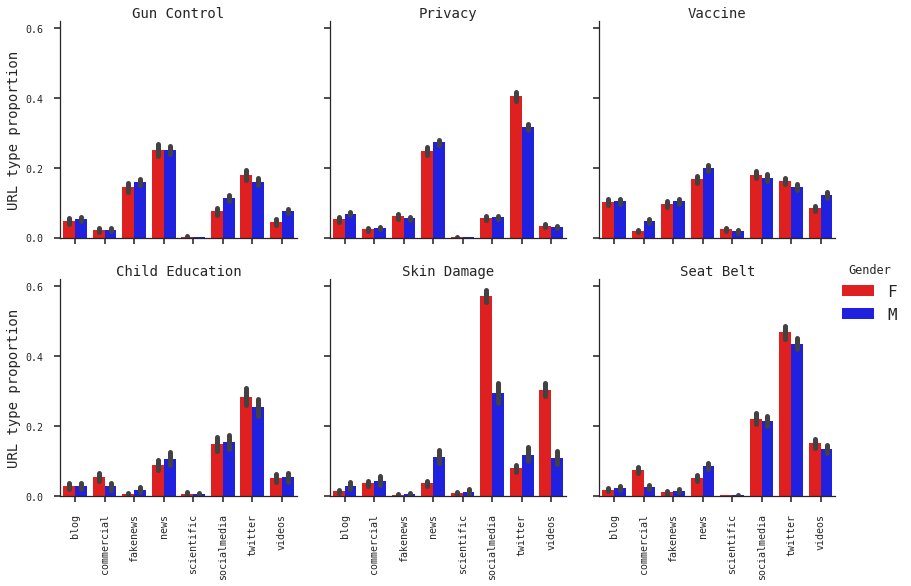

In [68]:
%%time
with sns.plotting_context(
    rc={"axes.titlesize": 14,
        "axes.labelsize": 14,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
       }), sns.axes_style(
    rc={"font.family": "monospace"}):
    g = sns.factorplot(x="URL_type", y="URL_counts", hue=u'Gender',
                   col="topic_name", col_wrap=3, 
                       col_order=topic_order,
                       kind="bar",
                       #color="0.2",
                       palette=["r", "b"],
                  data=pd.melt(pd.concat([df_X[df.t_n_urls > 0] > 0,
                                          df[df.t_n_urls > 0][["topic_name", u'Gender']],
                                          (df_y[df.t_n_urls > 0] == 1).to_frame()],
                      axis=1).drop(["NONE", "UNK"], axis=1),
                               id_vars=["is_controversial", u'Gender', "topic_name"],
            var_name="URL_type", value_name="URL_counts"
           ))
    g.set_xticklabels(rotation=90).set_titles("{col_name}").set_axis_labels("", "URL type proportion")
    #sns.despine(offset=10)

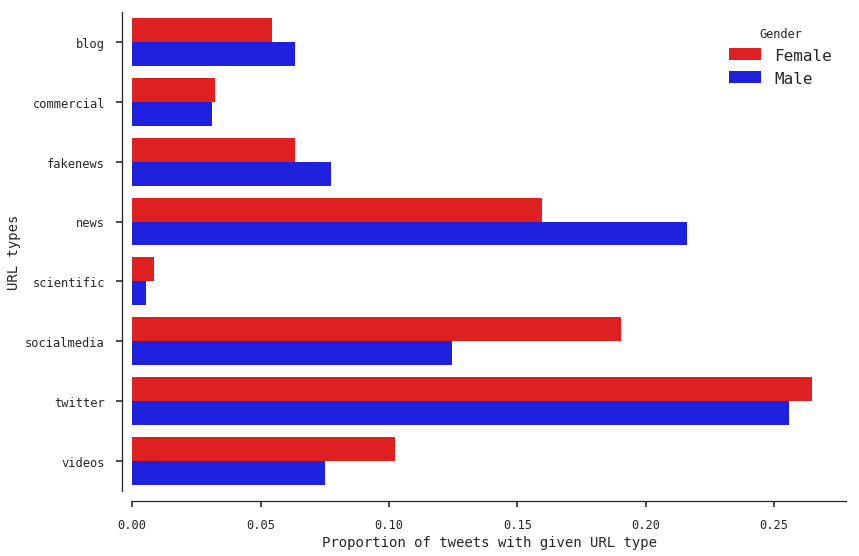

In [69]:
with sns.plotting_context(
    rc={"axes.titlesize": 14,
        "axes.labelsize": 14,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
       }), sns.axes_style(
    rc={"font.family": "monospace"}):
    ax = sns.barplot(x="mean", y="index", hue="Gender",
                data=pd.concat([
            ((df_X[(df.Gender == "F") & (df.t_n_urls > 0)].drop(["NONE", "UNK",], axis=1) > 0)* 1.).describe().T.reset_index().assign(Gender="Female"),
            ((df_X[(df.Gender == "M") & (df.t_n_urls > 0)].drop(["NONE", "UNK",], axis=1) > 0)* 1.).describe().T.reset_index().assign(Gender="Male"),
              ], axis=0),
                     palette=["r", "b"]
                    )
    ax.set_xlabel("Proportion of tweets with given URL type")
    ax.set_ylabel("URL types")
    sns.despine(offset=10)

In [70]:
(
    ((df_X[(df.Gender == "F") & (df.t_n_urls > 0)].drop(["NONE"], axis=1) > 0)* 1.).describe().T["mean"]/
    ((df_X[(df.Gender == "M") & (df.t_n_urls > 0)].drop(["NONE"], axis=1) > 0)* 1.).describe().T["mean"]
).to_frame().reset_index().rename(columns={"index": "URL type", "mean": "Odds in Females versus Males"})

,URL type,Odds in Females versus Males
0,UNK,0.972688
1,blog,0.853774
2,commercial,1.037645
3,fakenews,0.820768
4,news,0.738283
5,scientific,1.595711
6,socialmedia,1.528925
7,twitter,1.034922
8,videos,1.360646


In [71]:
model = sm.Logit.from_formula(("I((Gender == 'F') * 1.)"
                               "~ UNK + blog + commercial +"
                               " fakenews + news+ scientific"
                               " + socialmedia + twitter + videos -1"),
                              data=pd.concat([df.Gender[(df.t_n_urls > 0) & (df.Gender.isin({"M", "F"}))],
                 df_X[(df.t_n_urls > 0) & (df.Gender.isin({"M", "F"}))].drop("NONE", axis=1)], axis=1))
res = model.fit()
res.summary2()

Optimization terminated successfully.
         Current function value: 0.672335
         Iterations 4


<class 'statsmodels.iolib.summary2.Summary'>
"""
                             Results: Logit
=========================================================================
Model:              Logit                   Pseudo R-squared: 0.010      
Dependent Variable: I((Gender == 'F') * 1.) AIC:              65780.4237 
Date:               2017-03-12 20:04        BIC:              65859.6026 
No. Observations:   48906                   Log-Likelihood:   -32881.    
Df Model:           8                       LL-Null:          -33208.    
Df Residuals:       48897                   LLR p-value:      9.6414e-136
Converged:          1.0000                  Scale:            1.0000     
No. Iterations:     4.0000                                               
---------------------------------------------------------------------------
                  Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
---------------------------------------------------------------------------
UNK              -0.3578     0.0182   -19.6582   0.0000   -0.3935   -0.3222
blog             -0.4988     0.0381   -13.0986   0.0000   -0.5734   -0.4242
commercial       -0.2757     0.0503    -5.4781   0.0000   -0.3744   -0.1771
fakenews         -0.3559     0.0279   -12.7557   0.0000   -0.4106   -0.3012
news             -0.6215     0.0216   -28.7840   0.0000   -0.6638   -0.5792
scientific        0.3428     0.1124     3.0508   0.0023    0.1226    0.5630
socialmedia       0.2503     0.0349     7.1775   0.0000    0.1820    0.3187
twitter          -0.3043     0.0179   -16.9567   0.0000   -0.3395   -0.2691
videos           -0.2772     0.0459    -6.0335   0.0000   -0.3672   -0.1872
=========================================================================

"""

In [72]:
res.get_margeff().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
          Logit Marginal Effects          
==========================================
Dep. Variable:     I((Gender == 'F') * 1.)
Method:                               dydx
At:                                overall
===============================================================================
                 dy/dx    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
UNK            -0.0858      0.004    -19.972      0.000        -0.094    -0.077
blog           -0.1196      0.009    -13.190      0.000        -0.137    -0.102
commercial     -0.0661      0.012     -5.485      0.000        -0.090    -0.042
fakenews       -0.0853      0.007    -12.838      0.000        -0.098    -0.072
news           -0.1490      0.005    -29.774      0.000        -0.159    -0.139
scientific      0.0822      0.027      3.052      0.002         0.029     0.135
socialmedia     0.0600      0.008      7.193      0.000         0.044     0.076
twitter        -0.0730      0.004    -17.158      0.000        -0.081    -0.065
videos         -0.0665      0.011     -6.042      0.000        -0.088    -0.045
===============================================================================
"""